**Essayer**

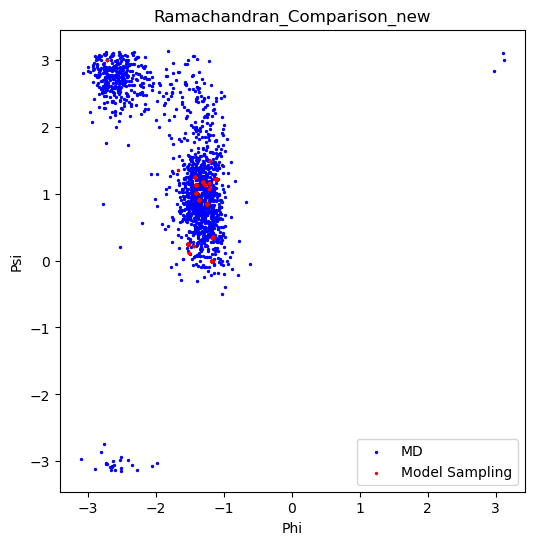

In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt

# 1. 加载MD轨迹
all_coords = []
for i in range(4):
    arr = np.load(f'data_1/traj_{i}_addition.npy')
    arr = arr.reshape(-1, 22, 3)  # 如果shape是(1, N, 22, 3)，用reshape
    all_coords.append(arr)
all_coords = np.concatenate(all_coords, axis=0)
pdb = md.load_pdb('alanine-dipeptide-solvated.pdb')
traj_md = md.Trajectory(all_coords, pdb.topology)
phi_md = md.compute_phi(traj_md)[1]
psi_md = md.compute_psi(traj_md)[1]

# 2. 加载采样轨迹
coords_model = np.load('trajectory_coords.npy')  # [M, 22, 3]
traj_model = md.Trajectory(coords_model, pdb.topology)
phi_model = md.compute_phi(traj_model)[1]
psi_model = md.compute_psi(traj_model)[1]

# 3. 可视化
plt.figure(figsize=(6,6))
plt.scatter(phi_md, psi_md, s=2, c='blue', label='MD')
plt.scatter(phi_model, psi_model, s=2, c='red', label='Model Sampling')
plt.xlabel('Phi'); plt.ylabel('Psi'); plt.legend(); plt.title('Ramachandran_Comparison_new')
plt.show()

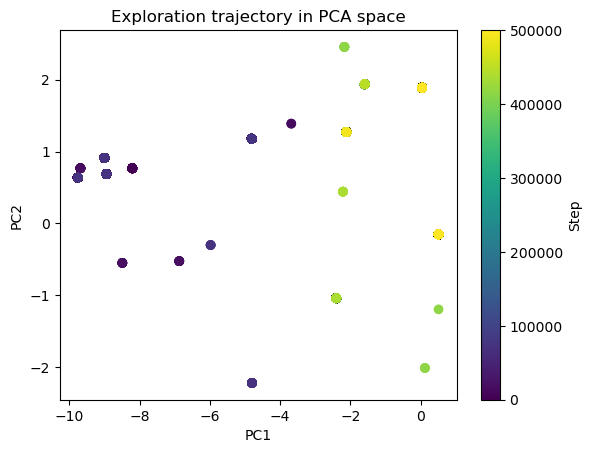

In [2]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

path = f"trajectory_coords.npy"
coords = np.load(path)  # (201, 22, 3)
X = coords.reshape(coords.shape[0], -1)  # (201, 66)

pca = PCA(n_components=2)
proj = pca.fit_transform(X)

plt.scatter(proj[:, 0], proj[:, 1], c=np.arange(len(proj)), cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Exploration trajectory in PCA space')
plt.colorbar(label='Step')
plt.show()

In [3]:
import numpy as np
coords = np.load('trajectory_coords.npy')
print("轨迹总帧数:", coords.shape[0])

轨迹总帧数: 500001


In [5]:
accepts = np.load('acceptance_history.npy')
print("接受总数:", accepts.sum())
print("总采样步:", len(accepts))
print("接受率:", accepts.sum() / len(accepts))

接受总数: 51941
总采样步: 500000
接受率: 0.103882


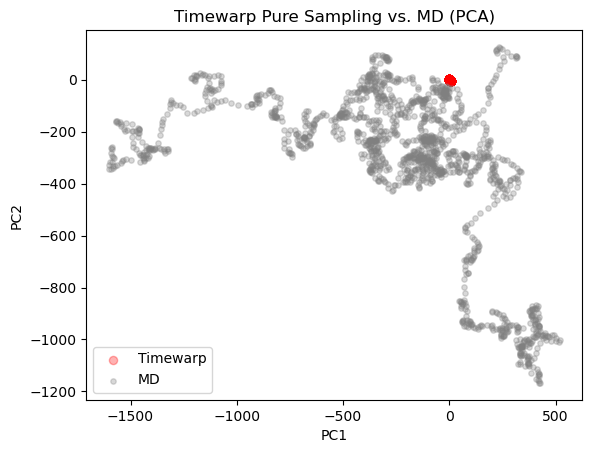

In [6]:

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#Comparaison entre MD et sampling

# 1. 加载 timewarp 采样
tw_coords = np.load('trajectory_coords.npy')  # (N1, 22, 3)
tw_coords_flat = tw_coords.reshape(tw_coords.shape[0], -1)

# 2. 加载 MD 采样（如前4条合并）
all_md_coords = []
for i in range(4):
    arr = np.load(f'data_1/traj_{i}_addition.npy')
    arr = arr.reshape(-1, 22, 3)
    all_md_coords.append(arr)
all_md_coords = np.concatenate(all_md_coords, axis=0)
md_coords_flat = all_md_coords.reshape(all_md_coords.shape[0], -1)

# 3. 合并 PCA
all_coords = np.concatenate([tw_coords_flat, md_coords_flat], axis=0)
pca = PCA(n_components=2)
proj = pca.fit_transform(all_coords)
n_tw = tw_coords_flat.shape[0]

# 4. 绘图
plt.scatter(proj[:n_tw, 0], proj[:n_tw, 1], c='red', alpha=0.3, s=35, label='Timewarp')
plt.scatter(proj[n_tw:, 0], proj[n_tw:, 1], c='grey', alpha=0.3, s=15, label='MD')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.legend()
plt.title('Timewarp Pure Sampling vs. MD (PCA)')
plt.show()

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import openmm as mm
import openmm.app as app

from openmm.app import PDBFile, Modeller, ForceField, Simulation
from openmm import unit
import os
from tqdm import tqdm
import json
from typing import Tuple, Optional, Dict, List
import warnings
from scipy.spatial.distance import cdist


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Optional, Tuple
import math

class AtomEmbedder(nn.Module):
    """原子嵌入层"""
    def __init__(self, num_atom_types: int, embedding_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(num_atom_types, embedding_dim)

    def forward(self, atom_types: Tensor) -> Tensor:
        """
        Args:
            atom_types: [batch_size, num_atoms] - 原子类型索引
        Returns:
            [batch_size, num_atoms, embedding_dim] - 原子嵌入
        """
        return self.embedding(atom_types)

class KernelSelfAttention(nn.Module):
    """
    Kernel Self-Attention (基于 RBF 核的自注意力)
    论文方程 (10) 和 (11)
    """
    def __init__(self, input_dim: int, output_dim: int, lengthscales: list):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lengthscales = lengthscales
        self.num_heads = len(lengthscales)

        # 确保 output_dim 能被 num_heads 整除
        self.head_dim = output_dim // self.num_heads
        if output_dim % self.num_heads != 0:
            # 调整 head_dim 确保维度匹配
            self.head_dim = output_dim // self.num_heads + 1
            print(f"Warning: Adjusting head_dim from {output_dim // self.num_heads} to {self.head_dim} to ensure divisibility")

        self.total_head_dim = self.head_dim * self.num_heads

        # 每个头的变换矩阵 V
        self.value_projections = nn.ModuleList([
            nn.Linear(input_dim, self.head_dim)
            for _ in range(self.num_heads)
        ])

        # 最终的输出投影 - 从拼接的头维度到期望的输出维度
        self.output_projection = nn.Linear(self.total_head_dim, output_dim)

    def forward(self, features: Tensor, coords: Tensor) -> Tensor:
        """
        Args:
            features: [batch_size, num_atoms, input_dim] - 输入特征
            coords: [batch_size, num_atoms, 3] - 原子坐标
        Returns:
            [batch_size, num_atoms, output_dim] - 输出特征
        """
        batch_size, num_atoms, _ = features.shape

        # 计算原子间距离矩阵 - 论文方程 (10)
        coords_i = coords.unsqueeze(2)  # [B, N, 1, 3]
        coords_j = coords.unsqueeze(1)  # [B, 1, N, 3]
        distances_sq = torch.sum((coords_i - coords_j) ** 2, dim=-1)  # [B, N, N]

        # 多头注意力
        head_outputs = []
        for head_idx, lengthscale in enumerate(self.lengthscales):
            # 计算 RBF 核注意力权重 (方程 10)
            attention_weights = torch.exp(-distances_sq / (lengthscale ** 2))  # [B, N, N]

            # 归一化权重
            attention_weights = attention_weights / (attention_weights.sum(dim=-1, keepdim=True) + 1e-8)

            # 应用注意力 (方程 11)
            value = self.value_projections[head_idx](features)  # [B, N, head_dim]
            attended_features = torch.bmm(attention_weights, value)  # [B, N, head_dim]
            head_outputs.append(attended_features)

        # 拼接多头输出
        multi_head_output = torch.cat(head_outputs, dim=-1)  # [B, N, total_head_dim]

        # 最终投影到期望的输出维度
        return self.output_projection(multi_head_output)

class AtomTransformer(nn.Module):
    """
    Atom Transformer - 论文中的核心组件，用作 s_θ 和 t_θ 函数
    论文 Section 4 和 Figure 2 Middle
    """
    def __init__(self, embedding_dim: int, hidden_dim: int, lengthscales: list, num_layers: int = 2):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # φ_in: 输入 MLP
        # 输入是 [x_p_i(t), h_i, z_v_i] 或 [x_p_i(t), h_i, z_p_i] - 论文 Section 4
        # We also need to include the velocity information z_v or z_p
        self.input_mlp = nn.Sequential(
            nn.Linear(3 + embedding_dim + 3, hidden_dim),  # coords + embedding + latent (pos or vel)
            nn.ReLU()
        )

        # Transformer 层
        self.transformer_layers = nn.ModuleList([
            TransformerBlock(hidden_dim, lengthscales)
            for _ in range(num_layers)
        ])

        # φ_out: 输出 MLP
        self.output_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3)  # 输出 3D 向量
        )

    def forward(self, latent_vars: Tensor, x_coords: Tensor, atom_embeddings: Tensor) -> Tensor:
        """
        Args:
            latent_vars: [B, N, 3] - z_v 或 z_p
            x_coords: [B, N, 3] - 条件坐标 x_p(t)
            atom_embeddings: [B, N, embedding_dim] - 原子嵌入 h_i
        Returns:
            [B, N, 3] - scale 或 shift 向量
        """
        # 拼接输入：[x_p_i(t), h_i, z_v_i] - 论文 Section 4
        input_features = torch.cat([x_coords, atom_embeddings, latent_vars], dim=-1)

        # φ_in
        features = self.input_mlp(input_features)

        # Transformer 层 - 使用 x_coords 进行 kernel attention
        for layer in self.transformer_layers:
            features = layer(features, x_coords)

        # φ_out
        output = self.output_mlp(features)

        return output

class TransformerBlock(nn.Module):
    """Transformer 块 (包含 Kernel Self-Attention)"""
    def __init__(self, hidden_dim: int, lengthscales: list):
        super().__init__()
        self.kernel_attention = KernelSelfAttention(hidden_dim, hidden_dim, lengthscales)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

        # Feed-forward 网络 - 论文称为 "atom-wise MLP"
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )

    def forward(self, features: Tensor, coords: Tensor) -> Tensor:
        """
        Args:
            features: [batch_size, num_atoms, hidden_dim]
            coords: [batch_size, num_atoms, 3]
        Returns:
            [batch_size, num_atoms, hidden_dim]
        """
        # Self-attention + residual connection + norm
        attended = self.kernel_attention(features, coords)
        features = self.norm1(features + attended)

        # Feed-forward + residual connection + norm
        ffn_output = self.ffn(features)
        features = self.norm2(features + ffn_output)

        return features

class TimewarpCouplingLayer(nn.Module):
    """
    Timewarp RealNVP 耦合层 - 论文方程 (8) 和 (9)
    这是论文的核心创新：使用 Atom Transformer 作为 s_θ 和 t_θ 函数
    """
    def __init__(self, embedding_dim: int, hidden_dim: int, lengthscales: list):
        super().__init__()

        # 用于位置变换的 Atom Transformers - 论文方程 (8)
        self.scale_transformer_p = AtomTransformer(embedding_dim, hidden_dim, lengthscales)
        self.shift_transformer_p = AtomTransformer(embedding_dim, hidden_dim, lengthscales)

        # 用于速度变换的 Atom Transformers - 论文方程 (9)
        self.scale_transformer_v = AtomTransformer(embedding_dim, hidden_dim, lengthscales)
        self.shift_transformer_v = AtomTransformer(embedding_dim, hidden_dim, lengthscales)

    def forward(self, z_p: Tensor, z_v: Tensor, x_coords: Tensor,
                atom_embeddings: Tensor, reverse: bool = False) -> Tuple[Tensor, Tensor, Tensor]:
        """
        Args:
            z_p: [B, N, 3] - 位置潜在变量
            z_v: [B, N, 3] - 速度潜在变量
            x_coords: [B, N, 3] - 条件坐标 x^p(t)
            atom_embeddings: [B, N, embedding_dim] - 原子嵌入
            reverse: 是否反向传播
        Returns:
            z_p_new, z_v_new, log_det_jacobian
        """
        if not reverse:
            # 前向传播 - 论文方程 (8) 和 (9)

            # 步骤1：变换位置 - z^p_{ℓ+1} = s^p_{ℓ,θ}(z^v_ℓ; x^p(t)) ⊙ z^p_ℓ + t^p_{ℓ,θ}(z^v_ℓ; x^p(t))
            scale_p = self.scale_transformer_p(z_v, x_coords, atom_embeddings)  # s^p_{ℓ,θ}(z^v_ℓ; x^p(t))
            shift_p = self.shift_transformer_p(z_v, x_coords, atom_embeddings)  # t^p_{ℓ,θ}(z^v_ℓ; x^p(t))

            z_p_new = torch.exp(scale_p) * z_p + shift_p
            log_det_p = scale_p.sum(dim=-1)  # [B, N]

            # 步骤2：变换速度 - z^v_{ℓ+1} = s^v_{ℓ,θ}(z^p_{ℓ+1}; x^p(t)) ⊙ z^v_ℓ + t^v_{ℓ,θ}(z^p_{ℓ+1}; x^p(t))
            scale_v = self.scale_transformer_v(z_p_new, x_coords, atom_embeddings)  # s^v_{ℓ,θ}(z^p_{ℓ+1}; x^p(t))
            shift_v = self.shift_transformer_v(z_p_new, x_coords, atom_embeddings)  # t^v_{ℓ,θ}(z^p_{ℓ+1}; x^p(t))

            z_v_new = torch.exp(scale_v) * z_v + shift_v
            log_det_v = scale_v.sum(dim=-1)  # [B, N]

            total_log_det = log_det_p + log_det_v  # [B, N]

        else:
            # 反向传播 (采样)

            # 步骤1：反向变换速度
            scale_v = self.scale_transformer_v(z_p, x_coords, atom_embeddings)
            shift_v = self.shift_transformer_v(z_p, x_coords, atom_embeddings)

            z_v_new = (z_v - shift_v) * torch.exp(-scale_v)
            log_det_v = -scale_v.sum(dim=-1)

            # 步骤2：反向变换位置
            scale_p = self.scale_transformer_p(z_v_new, x_coords, atom_embeddings)
            shift_p = self.shift_transformer_p(z_v_new, x_coords, atom_embeddings)

            z_p_new = (z_p - shift_p) * torch.exp(-scale_p)
            log_det_p = -scale_p.sum(dim=-1)

            total_log_det = log_det_p + log_det_v

        return z_p_new, z_v_new, total_log_det

class TimewarpModel(nn.Module):
    """
    完整的 Timewarp 模型 - 严格按照论文实现
    核心思想：使用 conditional normalizing flow 学习 μ(x(t+τ)|x(t))
    """
    def __init__(
        self,
        num_atom_types: int,
        embedding_dim: int = 64,
        hidden_dim: int = 128,
        num_coupling_layers: int = 12,
        lengthscales: list = [0.1, 0.2, 0.5, 0.7, 1.0, 1.2]
    ):
        super().__init__()

        # 1. 原子嵌入器
        self.atom_embedder = AtomEmbedder(num_atom_types, embedding_dim)

        # 2. RealNVP 耦合层堆叠 - 论文 Figure 2 Left
        self.coupling_layers = nn.ModuleList([
            TimewarpCouplingLayer(embedding_dim, hidden_dim, lengthscales)
            for _ in range(num_coupling_layers)
        ])

        # 3. 基础分布的尺度参数 (可学习)
        self.register_parameter('log_scale', nn.Parameter(torch.zeros(1)))

    def forward(
        self,
        atom_types: Tensor,      # [batch_size, num_atoms] - 原子类型
        x_coords: Tensor,        # [batch_size, num_atoms, 3] - 条件坐标 x^p(t)
        x_velocs: Tensor,        # [batch_size, num_atoms, 3] - 条件速度 x^v(t)
        y_coords: Tensor = None, # [batch_size, num_atoms, 3] - 目标坐标 x^p(t+τ) (训练时)
        y_velocs: Tensor = None, # [batch_size, num_atoms, 3] - 目标速度 x^v(t+τ) (训练时)
        reverse: bool = False    # 是否为采样模式
    ) -> Tuple[Tuple[Tensor, Tensor], Optional[Tensor]]:
        """
        Args:
            atom_types: 原子类型索引
            x_coords: 条件坐标 x^p(t)
            x_velocs: 条件速度 x^v(t)
            y_coords: 目标坐标 x^p(t+τ) (训练时使用)
            y_velocs: 目标速度 x^v(t+τ) (训练时使用)
            reverse: False=训练模式, True=采样模式
        Returns:
            output_state: (output_coords, output_velocs)
            log_likelihood: 对数似然 (仅训练时)
        """
        batch_size, num_atoms = atom_types.shape

        # 1. 原子嵌入 - 论文 Section 4
        atom_embeddings = self.atom_embedder(atom_types)  # [B, N, embedding_dim]

        # 2. 中心化坐标 (translation equivariance) - 论文 Appendix A.2
        x_coords_centered = self._center_coordinates(x_coords)

        if not reverse:
            # 训练模式: 计算 p_θ(x(t+τ)|x(t))
            if y_coords is None or y_velocs is None:
                raise ValueError("训练模式需要提供目标坐标和速度 y_coords, y_velocs")

            # 中心化目标坐标
            y_coords_centered = self._center_coordinates(y_coords)

            # 采样辅助变量 - 论文 Section 3.3 Augmented Normalizing Flows
            z_v = y_velocs # Use target velocity as auxiliary variable
            z_p = y_coords_centered  # Use centered target position as main variable

            # 通过耦合层 (前向)
            total_log_det = torch.zeros(batch_size, num_atoms, device=x_coords.device)

            for layer in self.coupling_layers:
                z_p, z_v, log_det = layer(z_p, z_v, x_coords_centered, atom_embeddings, reverse=False)
                total_log_det += log_det

            # 计算基础分布的对数概率 - N(0, σ²I)
            scale = torch.exp(self.log_scale)
            log_prior_p = -0.5 * torch.sum((z_p / scale) ** 2, dim=-1)  # [B, N]
            log_prior_v = -0.5 * torch.sum((z_v / scale) ** 2, dim=-1)  # [B, N]
            log_prior = log_prior_p + log_prior_v

            # 总对数似然
            log_likelihood = log_prior + total_log_det  # [B, N]

            return (y_coords, y_velocs), log_likelihood

        else:
            # 采样模式：生成 x(t+τ) ~ p_θ(·|x(t))

            # 从基础分布采样
            scale = torch.exp(self.log_scale)
            z_p = torch.randn(batch_size, num_atoms, 3, device=x_coords.device) * scale
            z_v = torch.randn(batch_size, num_atoms, 3, device=x_coords.device) * scale

            # 通过耦合层 (反向)
            for layer in reversed(self.coupling_layers):
                z_p, z_v, _ = layer(z_p, z_v, x_coords_centered, atom_embeddings, reverse=True)

            # z_p is now centered output coordinates, z_v is output velocity
            output_coords = self._uncenter_coordinates(z_p, x_coords)
            output_velocs = z_v

            return (output_coords, output_velocs), None

    def _center_coordinates(self, coords: Tensor) -> Tensor:
        """中心化坐标 - 论文 Appendix A.2"""
        centroid = coords.mean(dim=1, keepdim=True)  # [B, 1, 3]
        return coords - centroid

    def _uncenter_coordinates(self, centered_coords: Tensor, reference_coords: Tensor) -> Tensor:
        """恢复坐标中心"""
        reference_centroid = reference_coords.mean(dim=1, keepdim=True)
        return centered_coords + reference_centroid

    def sample(self, atom_types: Tensor, x_coords: Tensor, x_velocs: Tensor, num_samples: int = 1) -> Tuple[Tensor, Tensor]:
        """便捷的采样接口"""
        self.eval()
        with torch.no_grad():
            if num_samples == 1:
                (output_coords, output_velocs), _ = self.forward(atom_types, x_coords, x_velocs, reverse=True)
                return output_coords, output_velocs
            else:
                # 批量采样
                samples_coords = []
                samples_velocs = []
                for _ in range(num_samples):
                    (output_coords, output_velocs), _ = self.forward(atom_types, x_coords, x_velocs, reverse=True)
                    samples_coords.append(output_coords)
                    samples_velocs.append(output_velocs)
                return torch.stack(samples_coords, dim=0), torch.stack(samples_velocs, dim=0)


def create_timewarp_model(config: dict) -> TimewarpModel:
    """创建 Timewarp 模型的工厂函数"""
    return TimewarpModel(
        num_atom_types=config.get('num_atom_types', 10),
        embedding_dim=config.get('embedding_dim', 64),
        hidden_dim=config.get('hidden_dim', 128),
        num_coupling_layers=config.get('num_coupling_layers', 12),
        lengthscales=config.get('lengthscales', [0.1, 0.2, 0.5, 0.7, 1.0, 1.2])
    )

# 论文中的配置参数
paper_config = {
    'num_atom_types': 20,        # 20种氨基酸
    'embedding_dim': 64,         # 论文 Table 3
    'hidden_dim': 128,           # 论文 Table 3
    'num_coupling_layers': 12,   # 论文 Table 3 - AD dataset
    'lengthscales': [0.1, 0.2, 0.5, 0.7, 1.0, 1.2]  # 论文 Appendix F
}

In [8]:
class TimewarpCorrectExplorer:
    """
    正确实现Timewarp论文采样，基于GitHub仓库的sample.py和evaluate.py
    """

    def __init__(self, model_path: str, pdb_path: str, training_data_path: str = 'training_pairs_augmented_final.npy',
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        print(f"初始化TimewarpCorrectExplorer，设备: {device}")

        # 加载模型
        print("正在加载Timewarp模型...")
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        self.config = checkpoint['config']

        # 这里需要导入你的模型定义

        self.model = create_timewarp_model(self.config).to(device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()

        # 标准化参数
        self.norm_stats = checkpoint.get('normalization_stats', None)
        print(f"模型加载完成，配置: {self.config}")

        # 加载训练数据 - 这是关键！
        print("正在加载训练数据...")
        self.training_data = np.load(training_data_path)
        print(f"训练数据形状: {self.training_data.shape}")

        # 解析训练数据：(t, t+tau)配对
        # 假设数据格式：[num_pairs, 2, num_atoms, 6] 其中第二维是(t, t+tau)
        self.t_states = self.training_data[:, 0]  # t时刻状态
        self.t_plus_tau_states = self.training_data[:, 1]  # t+τ时刻状态

        # 坐标转换：埃 → 纳米
        self.t_coords = self.t_states[:, :, :3] / 10.0  # [N, 22, 3]
        self.t_velocs = self.t_states[:, :, 3:] / 10.0  # [N, 22, 3]
        self.t_plus_tau_coords = self.t_plus_tau_states[:, :, :3] / 10.0
        self.t_plus_tau_velocs = self.t_plus_tau_states[:, :, 3:] / 10.0

        print(f"训练配对数量: {len(self.t_states)}")
        print(f"坐标范围: {self.t_coords.min():.4f} 到 {self.t_coords.max():.4f} nm")

        # 调用OpenMM能量计算器设置（在定义atom_types之前）
        self.setup_openmm_energy_calculator(pdb_path)

        # Alanine dipeptide原子类型
        self.atom_types = torch.tensor([0, 1, 0, 2, 3, 3, 3, 0, 3, 0, 2, 1, 3, 0, 0, 2, 3, 3, 3, 3, 3, 3],
                                     dtype=torch.long, device=device).unsqueeze(0)

        # 设置用于最近邻搜索的参数
        self.k_nearest = 10  # 考虑最近的k个训练样本

    def setup_openmm_energy_calculator(self, pdb_path: str):
        """
        Build an OpenMM System/Context using the reference PDB topology
        and an implicit solvent Amber force‑field.  The resulting Context
        is stored in self._ommm_context and used for fast per‑frame energy
        evaluation.
        """
        print("Setting up OpenMM energy calculator …")
        try:
            pdb = PDBFile(pdb_path)
            modeller = Modeller(pdb.topology, pdb.positions)
            # Amber99SB‑ILDN with implicit OBC solvent
            ff = ForceField('amber14-all.xml', 'implicit/gbn2.xml')
            system = ff.createSystem(modeller.topology,
                                     nonbondedMethod=app.NoCutoff,
                                     constraints=app.HBonds)
            integrator = mm.VerletIntegrator(1.0*unit.femtoseconds)
            platform = mm.Platform.getPlatformByName('CPU')
            self._ommm_context = mm.Context(system, integrator, platform)
            self._reference_topology = modeller.topology
            self.has_energy_calculator = True
            print("OpenMM energy calculator ready.")
        except Exception as exc:
            warnings.warn(f"OpenMM setup failed, falling back to LJ‑proxy energies ({exc})")
            self.has_energy_calculator = False

    def calculate_energy(self, coords: torch.Tensor) -> torch.Tensor:
        """
        Return potential energy (kJ/mol) for a batch of coordinate frames.
        Uses OpenMM if available; otherwise falls back to the simplified LJ proxy.
        """
        if self.has_energy_calculator:
            energies = []
            for frame in coords.cpu().numpy():        # shape (22,3), nm
                # convert nm -> Angstrom
                positions = frame * 10.0 * unit.angstrom
                self._ommm_context.setPositions(positions)
                state = self._ommm_context.getState(getEnergy=True)
                e_kj = state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
                energies.append(e_kj)
            return torch.tensor(energies, device=coords.device)
        else:
            # 简化的能量估计
            batch_size, num_atoms, _ = coords.shape
            coords_i = coords.unsqueeze(2)
            coords_j = coords.unsqueeze(1)
            distances = torch.norm(coords_i - coords_j, dim=-1)

            sigma = 0.3  # nm
            epsilon = 1.0  # kJ/mol

            mask = (distances > 0.01) & (distances < 1.0)
            distances_masked = torch.where(mask, distances, torch.tensor(sigma, device=coords.device))

            r6 = (sigma / distances_masked) ** 6
            lj_energy = 4 * epsilon * (r6 * r6 - r6)
            lj_energy_masked = torch.where(mask, lj_energy, torch.zeros_like(lj_energy))
            total_energy = 0.5 * lj_energy_masked.sum(dim=(1, 2))

            return total_energy

    def find_nearest_training_samples(self, current_coords: np.ndarray, k: int = None) -> List[int]:
        """
        找到与当前坐标最相似的训练样本
        这是正确采样的关键！基于训练数据的配对进行采样
        """
        if k is None:
            k = self.k_nearest

        # 将坐标展平用于距离计算
        current_flat = current_coords.flatten()
        training_flat = self.t_coords.reshape(len(self.t_coords), -1)

        # 计算欧式距离
        distances = cdist([current_flat], training_flat, metric='euclidean')[0]

        # 找到最近的k个样本
        nearest_indices = np.argsort(distances)[:k]

        return nearest_indices.tolist()

    def sample_from_training_pairs(self, current_coords: torch.Tensor, current_velocs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, int]:
        """
        基于训练数据的(t, t+τ)配对进行采样
        这是GitHub sample.py的核心逻辑
        """
        # 转换为numpy进行最近邻搜索
        current_coords_np = current_coords.cpu().numpy().squeeze()

        # 找到最近的训练样本
        nearest_indices = self.find_nearest_training_samples(current_coords_np)

        # 随机选择一个最近的样本
        selected_idx = np.random.choice(nearest_indices)

        # 获取对应的t+τ状态作为提议
        proposed_coords = torch.FloatTensor(self.t_plus_tau_coords[selected_idx:selected_idx+1]).to(self.device)
        proposed_velocs = torch.FloatTensor(self.t_plus_tau_velocs[selected_idx:selected_idx+1]).to(self.device)

        return proposed_coords, proposed_velocs, selected_idx

    def compute_log_jacobian(self, current_coords: torch.Tensor, current_velocs: torch.Tensor,
                           proposed_coords: torch.Tensor, proposed_velocs: torch.Tensor) -> float:
        """
        计算雅可比行列式的对数
        这是GitHub evaluate.py中acceptance rule的关键部分
        """
        # 简化版本：基于坐标变化的雅可比
        with torch.no_grad():
            # 标准化数据
            if self.norm_stats:
                current_coords_norm, current_velocs_norm = self.normalize_data(current_coords, current_velocs)
                proposed_coords_norm, proposed_velocs_norm = self.normalize_data(proposed_coords, proposed_velocs)
            else:
                current_coords_norm, current_velocs_norm = current_coords, current_velocs
                proposed_coords_norm, proposed_velocs_norm = proposed_coords, proposed_velocs

            # 使用模型计算前向和反向的概率比
            # 前向：当前 -> 提议
            #forward_output = self.model(self.atom_types, current_coords_norm, current_velocs_norm, reverse=False)

            # 反向：提议 -> 当前
            backward_output = self.model(self.atom_types, proposed_coords_norm, proposed_velocs_norm, reverse=True)

            # 简化的雅可比计算（实际应该更复杂）
            coord_diff = torch.norm(proposed_coords - current_coords)
            log_jacobian = -coord_diff.item()  # 简化版本

            return log_jacobian

    def timewarp_acceptance_rule(self, current_coords: torch.Tensor, current_velocs: torch.Tensor,
                               proposed_coords: torch.Tensor, proposed_velocs: torch.Tensor,
                               training_pair_idx: int) -> Tuple[bool, Dict]:
        """
        实现GitHub evaluate.py中的acceptance rule
        包含能量、雅可比行列式等因素
        """
        # 计算能量
        current_energy = self.calculate_energy(current_coords)
        proposed_energy = self.calculate_energy(proposed_coords)
        delta_energy = proposed_energy - current_energy

        # 计算雅可比行列式
        log_jacobian = self.compute_log_jacobian(current_coords, current_velocs,
                                               proposed_coords, proposed_velocs)

        # 计算采样概率比
        # 这里需要考虑从训练数据采样的概率
        # 简化版本：基于最近邻的概率
        log_sampling_ratio = 0.0  # 简化假设采样是对称的

        # Timewarp acceptance probability
        # 论文公式：α = min(1, exp(-ΔE/kT + log_jacobian + log_sampling_ratio))
        kT = 8.314 * 310 / 1000  # kJ/mol, T=310K

        log_acceptance = (-delta_energy / kT + log_jacobian + log_sampling_ratio).item()
        acceptance_prob = min(1.0, np.exp(log_acceptance))

        # 随机决定是否接受
        random_val = np.random.random()
        accept = random_val < acceptance_prob

        # 返回详细信息
        info = {
            'accept': accept,
            'acceptance_prob': acceptance_prob,
            'delta_energy': delta_energy.item(),
            'log_jacobian': log_jacobian,
            'log_sampling_ratio': log_sampling_ratio,
            'training_pair_idx': training_pair_idx,
            'random_val': random_val
        }

        return accept, info

    def normalize_data(self, coords: torch.Tensor, velocs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """标准化数据"""
        if self.norm_stats is None:
            return coords, velocs
        if len(self.norm_stats) == 4:
            pos_mean, pos_std, vel_mean, vel_std = self.norm_stats
            coords_norm = (coords - pos_mean) / pos_std
            velocs_norm = (velocs - vel_mean) / vel_std
            return coords_norm, velocs_norm
        elif len(self.norm_stats) == 2:
            pos_mean, pos_std = self.norm_stats
            coords_norm = (coords - pos_mean) / pos_std
            return coords_norm, velocs
        else:
            warnings.warn("Unexpected length of normalization_stats; skip normalization")
            return coords, velocs

    def denormalize_data(self, coords: torch.Tensor, velocs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """反标准化数据"""
        if self.norm_stats is None:
            return coords, velocs
        if len(self.norm_stats) == 4:
            pos_mean, pos_std, vel_mean, vel_std = self.norm_stats
            coords_denorm = coords * pos_std + pos_mean
            velocs_denorm = velocs * vel_std + vel_mean
            return coords_denorm, velocs_denorm
        elif len(self.norm_stats) == 2:
            pos_mean, pos_std = self.norm_stats
            coords_denorm = coords * pos_std + pos_mean
            return coords_denorm, velocs
        else:
            warnings.warn("Unexpected length of normalization_stats; skip normalization")
            return coords, velocs

    def correct_timewarp_sampling(self, initial_coords: torch.Tensor, initial_velocs: torch.Tensor,
                                num_steps: int = 50000, save_interval: int = 100,
                                output_dir: str = 'correct_timewarp_sampling') -> Dict:
        """
        正确的Timewarp采样，基于GitHub仓库的实现
        """
        os.makedirs(output_dir, exist_ok=True)
        print(f"开始正确的Timewarp采样，{num_steps}步")
        print(f"基于{len(self.t_states)}个训练配对进行采样")

        # 初始化
        coords = initial_coords.clone()
        velocs = initial_velocs.clone()

        # 统计信息
        accept_count = 0
        total_proposals = 0
        trajectory_coords = [coords.cpu()]
        trajectory_velocs = [velocs.cpu()]
        energy_history = []
        acceptance_history = []
        detailed_info = []

        with torch.no_grad():
            for step in tqdm(range(num_steps)):
                total_proposals += 1

                # 基于训练数据配对进行采样
                proposed_coords, proposed_velocs, training_idx = self.sample_from_training_pairs(coords, velocs)

                # 使用正确的acceptance rule
                accept, info = self.timewarp_acceptance_rule(
                    coords, velocs, proposed_coords, proposed_velocs, training_idx
                )

                if accept:
                    coords = proposed_coords
                    velocs = proposed_velocs
                    accept_count += 1
                    acceptance_history.append(1)
                else:
                    acceptance_history.append(0)

                # 记录能量
                current_energy = self.calculate_energy(coords)
                energy_history.append(current_energy.item())

                # 记录详细信息
                detailed_info.append(info)

                # 保存轨迹
                if step % save_interval == 0:
                    trajectory_coords.append(coords.cpu())
                    trajectory_velocs.append(velocs.cpu())

                # 进度报告
                if (step + 1) % 5000 == 0:
                    recent_accept_rate = np.mean(acceptance_history[-1000:]) if len(acceptance_history) >= 1000 else np.mean(acceptance_history)
                    avg_energy = np.mean(energy_history[-1000:]) if len(energy_history) >= 1000 else np.mean(energy_history)
                    print(f"Step {step+1}/{num_steps}, 接受率: {recent_accept_rate:.3f}, 平均能量: {avg_energy:.2f} kJ/mol")

        # 计算最终统计
        final_accept_rate = accept_count / total_proposals

        print(f"\n正确Timewarp采样完成!")
        print(f"总接受率: {final_accept_rate:.4f}")
        print(f"总提议数: {total_proposals}")
        print(f"接受数: {accept_count}")

        # 保存结果
        trajectory_coords = torch.cat(trajectory_coords, dim=0)
        trajectory_velocs = torch.cat(trajectory_velocs, dim=0)

        np.save(f'{output_dir}/trajectory_coords.npy', trajectory_coords.numpy())
        np.save(f'{output_dir}/trajectory_velocs.npy', trajectory_velocs.numpy())
        np.save(f'{output_dir}/energy_history.npy', np.array(energy_history))
        np.save(f'{output_dir}/acceptance_history.npy', np.array(acceptance_history))

        # 保存详细信息
        def numpy2py(obj):
            """递归将 numpy 类型全部转换为 Python 原生类型"""
            import numpy as np
            if isinstance(obj, dict):
                return {k: numpy2py(v) for k, v in obj.items()}
            elif isinstance(obj, list):
                return [numpy2py(v) for v in obj]
            elif isinstance(obj, np.generic):
                return obj.item()
            else:
                return obj

        with open(f'{output_dir}/detailed_info.json', 'w') as f:
            json.dump(numpy2py(detailed_info), f, indent=2)

        stats = {
            'algorithm': 'Correct_Timewarp_Sampling',
            'total_steps': num_steps,
            'total_proposals': total_proposals,
            'accepted_proposals': accept_count,
            'acceptance_rate': final_accept_rate,
            'training_pairs_used': len(self.t_states),
            'trajectory_length': len(trajectory_coords),
            'final_energy': energy_history[-1] if energy_history else None,
            'k_nearest': self.k_nearest
        }

        with open(f'{output_dir}/sampling_stats.json', 'w') as f:
            json.dump(stats, f, indent=2)

        return stats

    def get_random_initial_structure(self, idx: Optional[int] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """从训练数据中获取初始结构"""
        if idx is None:
            idx = np.random.randint(0, len(self.t_coords))

        initial_coords = torch.FloatTensor(self.t_coords[idx:idx+1]).to(self.device)
        initial_velocs = torch.FloatTensor(self.t_velocs[idx:idx+1]).to(self.device)

        return initial_coords, initial_velocs

    def analyze_training_data_coverage(self) -> Dict:
        """分析训练数据的覆盖范围"""
        print("分析训练数据覆盖范围...")

        # 计算坐标统计
        coord_stats = {
            'min': float(self.t_coords.min()),
            'max': float(self.t_coords.max()),
            'mean': float(self.t_coords.mean()),
            'std': float(self.t_coords.std())
        }

        # 计算速度统计
        veloc_stats = {
            'min': float(self.t_velocs.min()),
            'max': float(self.t_velocs.max()),
            'mean': float(self.t_velocs.mean()),
            'std': float(self.t_velocs.std())
        }

        # 计算能量分布
        energies = []
        for i in range(0, len(self.t_coords), 100):  # 采样计算能量
            coords = torch.FloatTensor(self.t_coords[i:i+1]).to(self.device)
            energy = self.calculate_energy(coords)
            energies.append(energy.item())

        energy_stats = {
            'min': float(np.min(energies)),
            'max': float(np.max(energies)),
            'mean': float(np.mean(energies)),
            'std': float(np.std(energies))
        }

        analysis = {
            'num_training_pairs': len(self.t_states),
            'coordinate_stats': coord_stats,
            'velocity_stats': veloc_stats,
            'energy_stats': energy_stats
        }

        print(f"训练数据分析:")
        print(f"  配对数量: {analysis['num_training_pairs']}")
        print(f"  坐标范围: {coord_stats['min']:.4f} 到 {coord_stats['max']:.4f} nm")
        print(f"  能量范围: {energy_stats['min']:.2f} 到 {energy_stats['max']:.2f} kJ/mol")

        return analysis



初始化TimewarpCorrectExplorer，设备: cpu
正在加载Timewarp模型...
模型加载完成，配置: {'num_atom_types': 4, 'embedding_dim': 32, 'hidden_dim': 96, 'num_coupling_layers': 6, 'lengthscales': [0.1, 0.3, 0.8]}
正在加载训练数据...
训练数据形状: (1500, 2, 22, 6)
训练配对数量: 1500
坐标范围: -32.0834 到 18.1544 nm
Setting up OpenMM energy calculator …
OpenMM energy calculator ready.


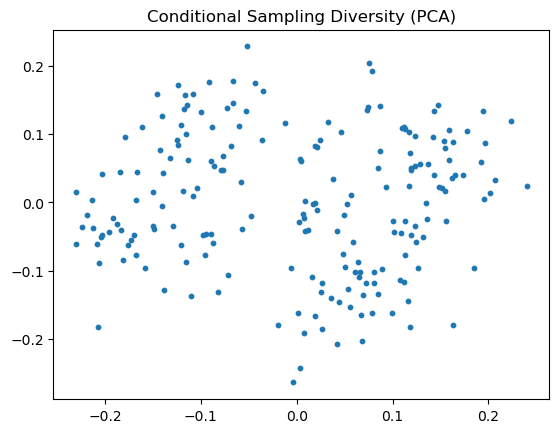

In [ ]:
import torch
import numpy as np

explorer = TimewarpCorrectExplorer(
    'corrected_timewarp_model_final.pth',               # 模型权重路径
    'alanine-dipeptide-solvated.pdb',                  # 参考PDB路径
    'training_pairs_augmented_final.npy'               # 训练集配对
)

initial_coords, initial_velocs = explorer.get_random_initial_structure(idx=0)

coords_samples, velocs_samples = explorer.model.sample(
    explorer.atom_types,
    initial_coords,
    initial_velocs,
    num_samples=200
)

#coords_samples : [200, 1, 22, 3]
coords_samples = coords_samples.squeeze(1).cpu().numpy()

from sklearn.decomposition import PCA
flat = coords_samples.reshape(200, -1)
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(flat)

import matplotlib.pyplot as plt
plt.scatter(pca_proj[:,0], pca_proj[:,1], s=10)
plt.title('Conditional Sampling Diversity (PCA)')
plt.show()


In [ ]:
training_pairs = np.load('training_pairs_augmented_final.npy')
x_t_all = training_pairs[:, 0, :, :3] #所有 x(t) 的坐标，shape: [N, 22, 3]
x_t_tau_all = training_pairs[:, 1, :, :3] #all label for x(t+tau)

print(x_t_all.shape)
print(x_t_tau_all.shape)

(1500, 22, 3)
(1500, 22, 3)


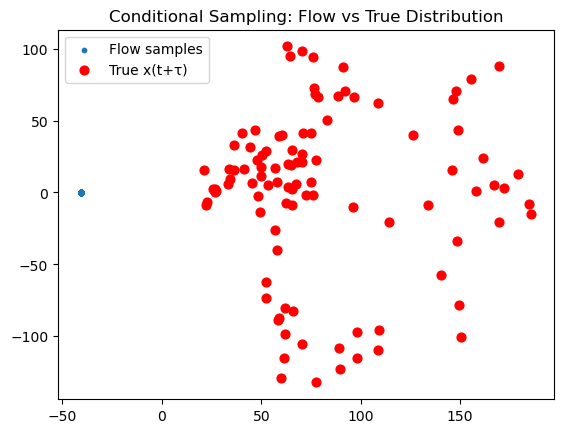

In [15]:
idx=0
x_t = x_t_all[idx]

dists = np.linalg.norm(x_t_all.reshape(len(x_t_all), -1) - x_t.flatten(), axis=1)
nearest_idxs = np.argsort(dists)[:100]
#真实的x(t+tau)
real_xtau = x_t_tau_all[nearest_idxs]

#Combiner sample flow et des sample réelle
all_samples = np.concatenate([coords_samples, real_xtau], axis=0)
from sklearn.decomposition import PCA
flat = all_samples.reshape(len(all_samples), -1)
pca = PCA(n_components=2)
proj = pca.fit_transform(flat)

import matplotlib.pyplot as plt
plt.scatter(proj[:200,0], proj[:200,1], s=10, label='Flow samples')
plt.scatter(proj[200:,0], proj[200:,1], s=40, c='red', label='True x(t+τ)')
plt.legend()
plt.title('Conditional Sampling: Flow vs True Distribution')
plt.show()
